<a href="https://colab.research.google.com/github/mingmcs/pyhealth/blob/week4/Tutorial_2_pyhealth_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyhealth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 5.2 MB/s 
     |████████████████████████████████| 29.3 MB 261 kB/s 


### **Instruction on [pyhealth.tasks](https://pyhealth.readthedocs.io/en/latest/api/tasks.html)**
- **[README]**: This module is used to define the healthcare AI task by **task function**. The **task function** specifics how to process each pateint's data (the structured dataset) into a set of samples for the downstream machine learning models. 
  - The current [pyhealth.tasks](https://pyhealth.readthedocs.io/en/latest/api/tasks.html) module contains several common healthcare tasks AS EXAMPLES, such as drug recommendation, length of stay prediction. Users can use our functions to work with existing tasks or define customized healthcare task functions.

- **[Arguments]**: 
  - `patient`: A [Patient](https://pyhealth.readthedocs.io/en/latest/api/data/pyhealth.data.Patient.html) object.

- **[Returns]**: 
    - `samples`: a list of samples, each sample is a dict with patient_id, visit_id, and other task-specific attributes as key

- **[Functionality]**: currently, we provide [the following tasks](https://pyhealth.readthedocs.io/en/latest/api/tasks.html) on the datasets:
  - drug_recommendation_mimic3_fn
  - readmission_prediction_mimic3_fn
  - mortality_prediction_mimic3_fn
  - length_of_stay_prediction_mimic3_fn
  - We provide similar functions for MIMIC-IV, eICU, and OMOP dataset.

  


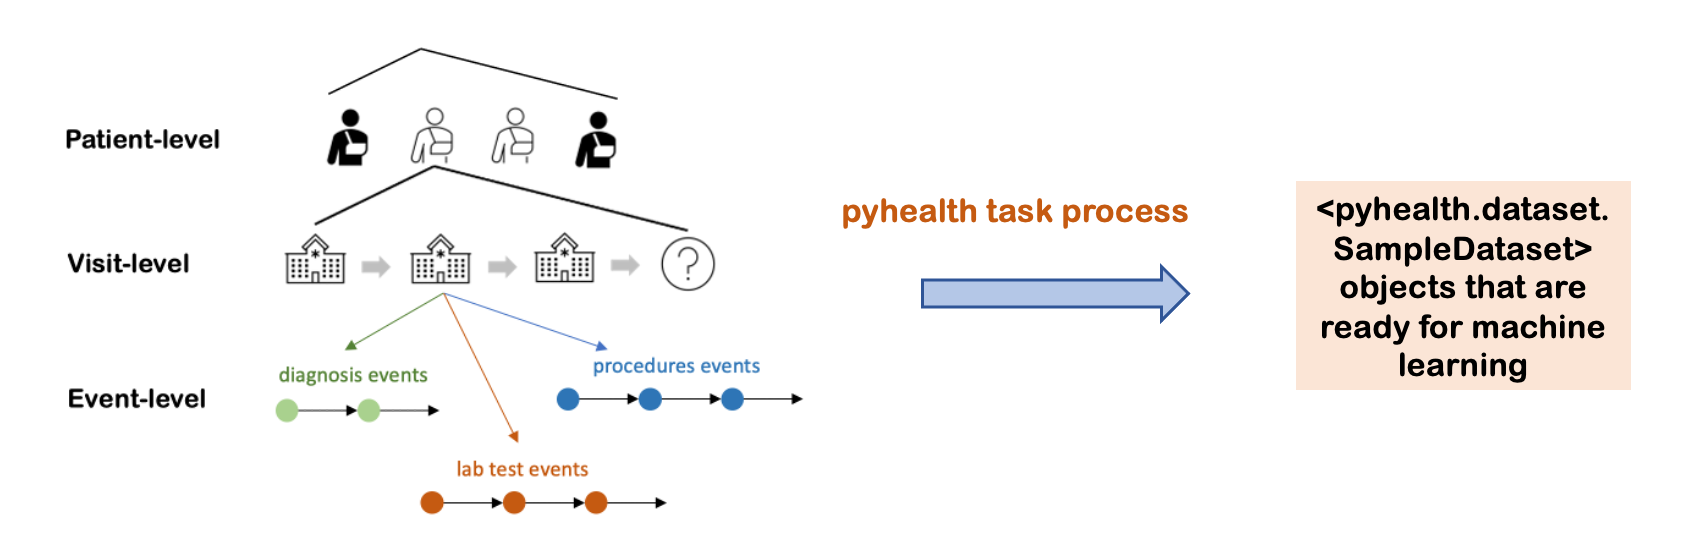

### **Example 1: Mortality Prediction on MIMIC-III**
- step 1: we use the DIAGNOSES_ICD, PROCEDURES_ICD table information.
- step 2: we remove visit that has empty conditions and procedures
- step 3: we create a dict-based sample and assign `mortality status` as the prediction target: `label`

#### Notes
- To lookup [visit](https://pyhealth.readthedocs.io/en/latest/api/data/pyhealth.data.Visit.html) attributes and functions
- To lookup [patient](https://pyhealth.readthedocs.io/en/latest/api/data/pyhealth.data.Patient.html) attributes and functions

In [ ]:
def mortality_prediction_mimic3_fn(patient):
    """
    Mortality prediction aims at predicting whether the patient will decease in the
        next hospital visit based on the clinical information from current visit
        (e.g., conditions and procedures).

    """
    samples = []
    for visit_idx in range(len(patient) - 1):
        visit = patient[visit_idx]
        next_visit = patient[visit_idx + 1]

        # obtain the label
        if next_visit.discharge_status not in [0, 1]:
            mortality_label = 0
        else:
            mortality_label = int(next_visit.discharge_status)

        # step 1: obtain features
        conditions = visit.get_code_list(table="DIAGNOSES_ICD")
        procedures = visit.get_code_list(table="PROCEDURES_ICD")

        # step 2: exclusion criteria
        if len(conditions) + len(procedures) == 0: continue

        # step 3: assemble the sample
        # REMEMBER: the key here will be the "feature_keys" and "label_key" for initializing the downstream model
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "conditions": conditions, # feature key 1
                "procedures": procedures, # feature key 2
                "label": mortality_label, # label key
            }
        )
    
    return samples

#### We apply this task function on MIIMC-III dataset

In [ ]:
from pyhealth.datasets import MIMIC3Dataset

dataset = MIMIC3Dataset(
    root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
    tables=["DIAGNOSES_ICD", "PROCEDURES_ICD"],
    dev=True,
)

Mapping codes: 100%|██████████| 1000/1000 [00:00<00:00, 71476.36it/s]


In practice, we will automatically iterate through all patients for you using the set_task() function.

In [ ]:
# use `.set_task()`, which returns a task dataset
task_ds = dataset.set_task(task_fn=mortality_prediction_mimic3_fn)

Generating samples for mortality_prediction_mimic3_fn: 100%|██████████| 1000/1000 [00:00<00:00, 105634.01it/s]


In [ ]:
# we show the statistic of the task
task_ds.stat()

Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: mortality_prediction_mimic3_fn
	- Number of samples: 53
	- Number of patients: 44
	- Number of visits: 53
	- Number of visits per patient: 1.2045
	- conditions:
		- Number of conditions per sample: 10.3962
		- Number of unique conditions: 335
		- Distribution of conditions (Top-10): [('4019', 14), ('4280', 14), ('25000', 12), ('2851', 9), ('53081', 9), ('41401', 9), ('311', 6), ('2762', 6), ('486', 6), ('2724', 6)]
	- procedures:
		- Number of procedures per sample: 2.8679
		- Number of unique procedures: 99
		- Distribution of procedures (Top-10): [('3893', 11), ('9904', 7), ('8872', 6), ('3995', 5), ('9604', 4), ('3722', 4), ('966', 3), ('9359', 3), ('4513', 2), ('4516', 2)]
	- label:
		- Number of label per sample: 1.0000
		- Number of unique label: 1
		- Distribution of label (Top-10): [(0, 53)]


"Statistics of sample dataset:\n\t- Dataset: MIMIC3Dataset\n\t- Task: mortality_prediction_mimic3_fn\n\t- Number of samples: 53\n\t- Number of patients: 44\n\t- Number of visits: 53\n\t- Number of visits per patient: 1.2045\n\t- conditions:\n\t\t- Number of conditions per sample: 10.3962\n\t\t- Number of unique conditions: 335\n\t\t- Distribution of conditions (Top-10): [('4019', 14), ('4280', 14), ('25000', 12), ('2851', 9), ('53081', 9), ('41401', 9), ('311', 6), ('2762', 6), ('486', 6), ('2724', 6)]\n\t- procedures:\n\t\t- Number of procedures per sample: 2.8679\n\t\t- Number of unique procedures: 99\n\t\t- Distribution of procedures (Top-10): [('3893', 11), ('9904', 7), ('8872', 6), ('3995', 5), ('9604', 4), ('3722', 4), ('966', 3), ('9359', 3), ('4513', 2), ('4516', 2)]\n\t- label:\n\t\t- Number of label per sample: 1.0000\n\t\t- Number of unique label: 1\n\t\t- Distribution of label (Top-10): [(0, 53)]"

In [ ]:
# what many keys are available?
task_ds.available_keys

['visit_id', 'patient_id', 'conditions', 'procedures', 'label']

In [ ]:
# check the first sample
task_ds.samples[0]

{'visit_id': '100144',
 'patient_id': '141',
 'conditions': [['27651',
   '311',
   '2768',
   '07070',
   '4928',
   '78001',
   '8730',
   '51889']],
 'procedures': [['9604', '370']],
 'label': 0}

##### TODO: Implement a task function to predict the mortality of the current visit

In [ ]:
def new_mortality_prediction_mimic3_fn(patient):
    """
    Mortality prediction aims at predicting whether the patient will decease in this
        hospital visit based on the clinical information from current visit
        (e.g., conditions and procedures).

    """
    samples = []
    for visit in patient:

        # obtain the label
        mortality_label = int(visit.discharge_status)

        # step 1: obtain features
        conditions = visit.get_code_list(table="DIAGNOSES_ICD")
        procedures = visit.get_code_list(table="PROCEDURES_ICD")

        # step 2: exclusion criteria
        if len(conditions) + len(procedures) == 0: continue

        # step 3: assemble the sample
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "conditions": conditions,
                "procedures": procedures,
                "label": mortality_label,
            }
        )
    
    return samples

### **Example 2: Readmission Prediction on MIMIC-IV data**
- step 1: we use condition, procedures and drugs information from tables `"diagnoses_icd"`, `"procedures_icd"`, `"prescriptions"`
- step 2: we remove visit that has empty conditions, procedures, and drugs
- step 3: we create a dict-based sample and assign `readmission label` as the prediction target: `label`

In [ ]:
def readmission_prediction_mimic4_fn(patient, time_window=15):
    """
    Readmission prediction aims at predicting whether the patient will be readmitted
        into hospital within time_window days based on the clinical information from
        current visit (e.g., conditions and procedures).
    """
    samples = []

    # we will drop the last visit
    for i in range(len(patient) - 1):
        visit = patient[i]
        next_visit = patient[i + 1]

        # obtain label: get time difference between current visit and next visit
        time_diff = (next_visit.encounter_time - visit.encounter_time).days
        readmission_label = 1 if time_diff < time_window else 0

        # step 1: obtain features
        conditions = visit.get_code_list(table="diagnoses_icd")
        procedures = visit.get_code_list(table="procedures_icd")
        drugs = visit.get_code_list(table="prescriptions")

        # step 2: exclusion criteria
        # exclude: visits without condition, procedure, and drug code
        if len(conditions) + len(procedures) + len(drugs) == 0: continue

        # step 3: assemble the sample
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "conditions": conditions,
                "procedures": procedures,
                "drugs": drugs,
                "label": readmission_label,
            }
        )

    return samples

"""
>>> from pyhealth.datasets import MIMIC4Dataset
>>> mimic4_base = MIMIC4Dataset(
...     root="/srv/local/data/physionet.org/files/mimiciv/2.0/hosp",
...     tables=["diagnoses_icd", "procedures_icd", "prescriptions"],
...     code_mapping={"ICD10PROC": "CCSPROC"},
... )

>>> from pyhealth.tasks import readmission_prediction_mimic4_fn
>>> mimic4_sample = mimic4_base.set_task(readmission_prediction_mimic4_fn)

>>> mimic4_sample.samples[0]
{
    'visit_id': '130744', 
    'patient_id': '103', 
    'diagnoses_icd': [5], 
    'conditions': [['42', '109', '19', '122', '98', '663', '58', '51']], 
    'procedures': [['1']], 
    'label': 0
}
"""

### **Example 3: Drug Recommendation on eICU**
- step 1: we use condition, procedures and drugs information from tables `"diagnosis"`, `"physicalExam"`, `"medication"`
- step 2: we remove visit that has empty conditions, procedures or drugs
- step 3: we create a dict-based sample and assigne `"drugs"` as the prediction target: `label`
- step 4: we remove patients with fewer than 2 visits and recursively add historical information for conditions, procedures and drugs (we remove the current set of drugs to prevent label leaking).

In [ ]:
def drug_recommendation_eicu_fn(patient):
    samples = []
    for visit in patient:

        # step 1: obtain visit-level information, conditions, procedures, and drugs
        conditions = visit.get_code_list(table="diagnosis")
        procedures = visit.get_code_list(table="physicalExam")
        drugs = visit.get_code_list(table="medication")

        # step 2: exclusion criteria: cohort selection
        if len(conditions) * len(procedures) * len(drugs) == 0: continue

        # step 3: assemble the sample
        # REMEMBER: the key here will be the "feature_keys" and "label_key" for initializing the downstream model
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "conditions": conditions,
                "procedures": procedures,
                "drugs": drugs,
                "label": drugs,
            }
        )

    # step 4: patient-level cohort selection and other process
    # exclude patients with less than 2 visit
    if len(samples) < 2:
        return []

    """ 
    Add historical visit (use "conditions" key as an example)
        before this step:
            samples[0]["conditions"]: 1st visit
            samples[1]["conditions"]: 2nd visit
            samples[2]["conditions"]: 3rd visit
            ...
        
        after this step:
            samples[0]["conditions"]: [1st visit]
            samples[1]["conditions"]: [1st visit, 2nd visit]
            samples[2]["conditions"]: [1st visit, 2nd visit, 3rd visit]
            ...
    """
    samples[0]["conditions"] = [samples[0]["conditions"]]
    samples[0]["procedures"] = [samples[0]["procedures"]]
    samples[0]["drugs"] = [samples[0]["drugs"]]

    for i in range(1, len(samples)):
        samples[i]["conditions"] = samples[i - 1]["conditions"] + [
            samples[i]["conditions"]
        ]
        samples[i]["procedures"] = samples[i - 1]["procedures"] + [
            samples[i]["procedures"]
        ]
        samples[i]["drugs"] = samples[i - 1]["drugs"] + [
            samples[i]["drugs"]
        ]
    for i in range(len(samples)):
        samples[i]["drugs"][i] = []

    return samples


"""
>>> from pyhealth.datasets import eICUDataset
>>> eicu_base = eICUDataset(
...     root="/srv/local/data/physionet.org/files/eicu-crd/2.0",
...     tables=["diagnosis", "medication"],
... )

>>> from pyhealth.tasks import drug_recommendation_eicu_fn
>>> eicu_sample = eicu_base.set_task(drug_recommendation_eicu_fn)

>>> eicu_sample.samples[0]
{
    'visit_id': '130744', 
    'patient_id': '103', 
    'conditions': [['42', '109', '98', '663', '58', '51']], 
    'procedures': [['1']],
    'label': [['2', '3', '4']]
}
"""

If you find it useful, please give us a star ⭐ (fork, and watch) at https://github.com/sunlabuiuc/PyHealth. 

Thanks very much for your support!